# load packages

In [1]:
import os  # Operating system utilities

# Standard Data Science Libraries
import numpy as np  # Numerical operations
import pandas as pd  # Data manipulation and analysis
import matplotlib.pyplot as plt  # Plotting library
import seaborn as sns  # Statistical data visualization

# Scikit-Learn for Preprocessing and Dimensionality Reduction
from sklearn.impute import SimpleImputer  # Handling missing values
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder  # Data normalization and encoding
from sklearn.decomposition import PCA  # Principal Component Analysis
from sklearn.manifold import TSNE  # t-SNE for dimensionality reduction
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score  # Clustering evaluation metrics

# UMAP for Dimensionality Reduction
import umap.umap_ as umap  # Uniform Manifold Approximation and Projection

# PyTorch and PyTorch Geometric 
import torch  # Deep learning framework
import torch.nn as nn  # Neural network modules
import torch.optim as optim  # Optimization algorithms
from torch.utils.data import Dataset, DataLoader  # Handling data in batches
from torch_geometric.nn import GINConv  # Graph Convolutional Layers
from torch_geometric.utils import dense_to_sparse, add_self_loops, subgraph  # Graph utilities

# Graph and Matrix Operations
from scipy.sparse.csgraph import laplacian  # Graph Laplacian calculation


# Data loading

Protein dataset

/home/labpc6c/anaconda3/lib/python3.9/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


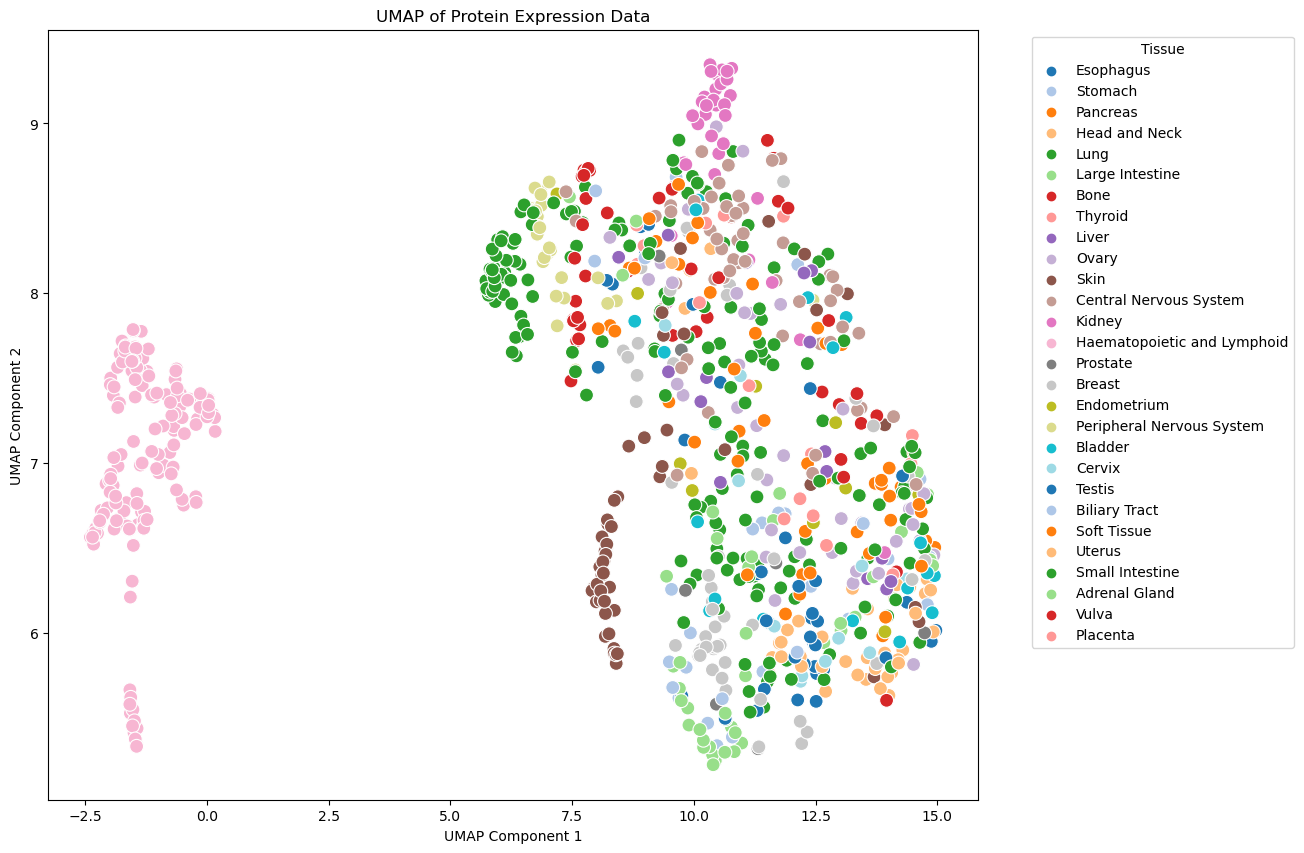

Processing complete. Saved protein data and PPI matrix.


In [2]:


# --- Set Working Directory & File Paths ---
os.chdir("/home/labpc6c/Documents/Mo_emam/GID_mo_emam/")
protein_path = "/home/labpc6c/Documents/Mo_emam/mmc3.xlsx"
mapping_path = "/home/labpc6c/Downloads/idmapping_2024_07_29.tsv"
gdsc_path = "/home/labpc6c/Downloads/GDSC1_fitted_dose_response_27Oct23.xlsx"
ppi_links_path = "/home/labpc6c/Documents/Mo_emam/9606.protein.links.v12.0.txt"
ppi_info_path = "/home/labpc6c/Documents/Mo_emam/9606.protein.info.v12.0.txt"
metadata_path = "./model_list_20230517.csv"

# --- Load & Preprocess Protein Data ---
def load_protein_data(path):
    """Load protein expression data, impute missing values, and normalize."""
    protein = pd.read_excel(path, sheet_name=1, skiprows=1, index_col=0)
    
    # Store original missing mask
    missing_mask = protein.isna()
    
    # Impute missing values with mean
    imputer = SimpleImputer(strategy='mean')
    df_imputed = pd.DataFrame(
        imputer.fit_transform(protein), 
        columns=protein.columns, 
        index=protein.index
    )
    
    # Min-Max normalization
    scaler = MinMaxScaler()
    normalized_data = pd.DataFrame(
        scaler.fit_transform(df_imputed),
        columns=df_imputed.columns,
        index=df_imputed.index
    )
    
    # Format columns/indices (e.g., "ID;Protein_Name" → "Protein_Name")
    normalized_data.columns = [col.split(';')[1] for col in protein.columns]
    normalized_data.index = [row.split(';')[0] for row in protein.index]
    missing_mask.columns = [col.split(';')[1] for col in protein.columns]
    missing_mask.index = [row.split(';')[0] for row in protein.index]
    
    return normalized_data, missing_mask

# --- Map Protein IDs to Standard Names ---
def map_protein_ids(data, mask, mapping_path):
    """Align protein IDs with standardized names from UniProt."""
    mapping_df = pd.read_csv(mapping_path, sep="\t", header=None, names=['From', 'To'])
    mapping_dict = dict(zip(mapping_df['From'], mapping_df['To']))
    
    # Filter and rename columns for both data and mask
    mapped_cols = [col for col in data.columns if col in mapping_dict]
    return (
        data[mapped_cols].rename(columns=mapping_dict),
        mask[mapped_cols].rename(columns=mapping_dict)
    )

# --- Load & Process Drug Response Data (GDSC) ---
def load_gdsc_data(path, protein_data):
    """Extract drug response (LN_IC50) and align with protein data cell lines."""
    gdsc_df = pd.read_excel(path)
    pivot_df = gdsc_df.pivot_table(
        index='SANGER_MODEL_ID', 
        columns='DRUG_NAME', 
        values='LN_IC50', 
        aggfunc='first'
    )
    return pivot_df[pivot_df.index.isin(protein_data.index)]

# --- Build PPI Network ---
def build_ppi_network(links_path, info_path, protein_data):
    """Create normalized adjacency matrix from STRING DB interactions."""
    # Load interaction data and protein names
    links = pd.read_csv(links_path, sep=' ')
    info = pd.read_csv(info_path, sep='\t')
    id_to_name = dict(zip(info['#string_protein_id'], info['preferred_name']))
    
    # Map IDs to names and filter high-confidence interactions (score >= 700)
    links['protein1'] = links['protein1'].map(id_to_name)
    links['protein2'] = links['protein2'].map(id_to_name)
    links_filtered = links[links['combined_score'] >= 700]
    
    # Create symmetric adjacency matrix
    valid_proteins = set(protein_data.columns)
    links_filtered = links_filtered[
        links_filtered['protein1'].isin(valid_proteins) & 
        links_filtered['protein2'].isin(valid_proteins)
    ]
    
    adj_matrix = pd.crosstab(links_filtered['protein1'], links_filtered['protein2'])
    adj_matrix = adj_matrix + adj_matrix.T.fillna(0)
    
    # Normalize with degree scaling
    degree = adj_matrix.sum(axis=1).values
    degree_sqrt_inv = np.diag(1.0 / np.sqrt(degree + 1e-8))
    adj_matrix_normalized = degree_sqrt_inv @ adj_matrix.values @ degree_sqrt_inv
    
    return pd.DataFrame(
        adj_matrix_normalized, 
        index=adj_matrix.index, 
        columns=adj_matrix.columns
    )

# --- UMAP Visualization for Protein Data ---
def plot_protein_umap(protein_data, metadata):
    """Visualize protein data using UMAP colored by tissue type."""
    umap_model = umap.UMAP(n_components=2, random_state=42)
    umap_result = umap_model.fit_transform(protein_data)
    
    plt.figure(figsize=(12, 10))
    sns.scatterplot(
        x=umap_result[:, 0], 
        y=umap_result[:, 1], 
        hue=metadata['tissue'],
        palette='tab20',
        s=100,
        legend='full'
    )
    plt.title('UMAP of Protein Expression Data')
    plt.xlabel('UMAP Component 1')
    plt.ylabel('UMAP Component 2')
    plt.legend(title='Tissue', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

# --- Main Execution ---
if __name__ == "__main__":
    # 1. Load and preprocess protein data
    protein_data, missing_mask = load_protein_data(protein_path)
    
    # 2. Map protein IDs to standardized names
    protein_data, missing_mask = map_protein_ids(protein_data, missing_mask, mapping_path)
    
    # 3. Load drug response data and filter overlapping cell lines
    drug_response = load_gdsc_data(gdsc_path, protein_data)
    protein_data = protein_data[protein_data.index.isin(drug_response.index)]
    missing_mask = missing_mask.loc[protein_data.index]
    
    # 4. Load metadata and encode tissue labels
    metadata = pd.read_csv(metadata_path, sep=",").set_index("model_id")
    metadata = metadata.loc[protein_data.index]
    metadata['tissue_encoded'] = LabelEncoder().fit_transform(metadata['tissue'])
    
    # 5. Build PPI network and align with protein data
    adj_matrix = build_ppi_network(ppi_links_path, ppi_info_path, protein_data)
    shared_proteins = adj_matrix.columns.intersection(protein_data.columns)
    final_protein_data = protein_data[shared_proteins]
    missing_mask_filtered = missing_mask[shared_proteins]
    
    # Remove duplicated columns, if any
    final_protein_data = final_protein_data.loc[:, ~final_protein_data.columns.duplicated()]
    missing_mask_filtered = missing_mask_filtered.loc[:, ~missing_mask_filtered.columns.duplicated()]
    # Apply Min-Max Normalization
    scaler = MinMaxScaler()
    # Normalize the final protein data using Min-Max Normalization
    final_protein_data = scaler.fit_transform(final_protein_data)
    # Create the final dataset by concatenating the protein data and the drug data
    final_protein_nromalized_dataset_ready = pd.DataFrame(final_protein_data, index=protein_data.index, columns=shared_proteins)

    # Create the final missing data mask by concatenating the protein and drug masks
    missing_final_protein_nromalized_dataset_ready = missing_mask_filtered
    # 6. Visualize protein data with UMAP
    plot_protein_umap(final_protein_nromalized_dataset_ready, metadata)
    
    # 3. Load drug response data and get pivot table
    pivot_df = load_gdsc_data(gdsc_path, protein_data)
    
   
    # 7. Save processed data
    protein_data.to_csv("processed_protein_data.csv")
    adj_matrix.to_csv("normalized_ppi_adj_matrix.csv")
    print("Processing complete. Saved protein data and PPI matrix.")
    
    





Transcriptome

/home/labpc6c/anaconda3/lib/python3.9/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


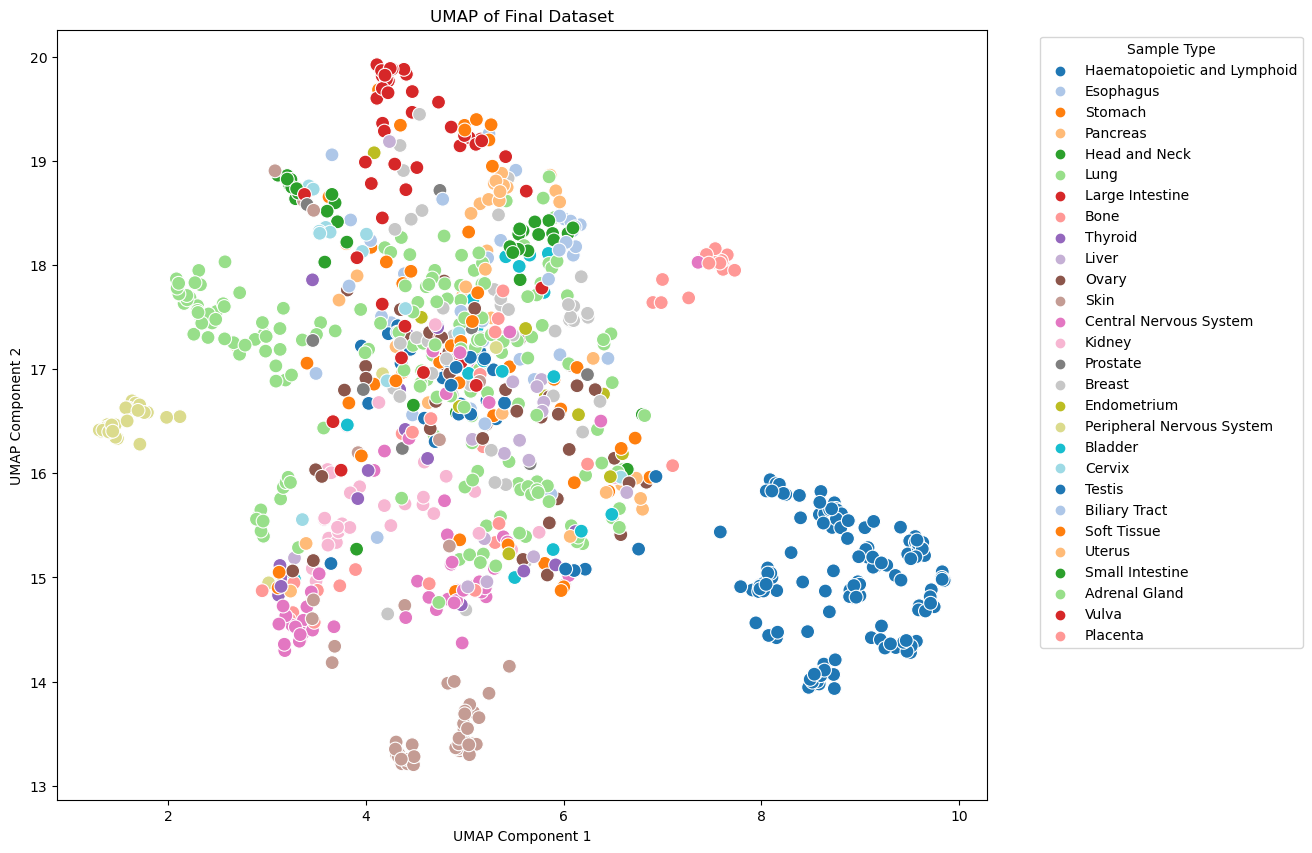

In [3]:

class TranscriptomeDataProcessor:
    def __init__(self, transcriptome_path, meta_path):
        self.transcriptome_path = transcriptome_path
        self.meta_path = meta_path
    
    def load_transcriptome_data(self):
        # Load the transcriptome data and transpose
        transcriptome_data = pd.read_csv(self.transcriptome_path, index_col=0)
        transcriptome_data = transcriptome_data.T
        return transcriptome_data
    
    def normalize_data(self, data):
        # Apply Min-Max Normalization
        scaler = MinMaxScaler()
        normalized_data = pd.DataFrame(scaler.fit_transform(data), columns=data.columns, index=data.index)
        return normalized_data
    
    def load_metadata(self):
        # Load the metadata
        meta_adata = pd.read_csv(self.meta_path, sep=",")
        meta_data = meta_adata.set_index("model_id")
        return meta_data
    
    def encode_metadata(self, meta_data, data):
        # Encode 'tissue' into numerical labels
        final_meta_data = meta_data.loc[data.index]
        label_encoder = LabelEncoder()
        final_meta_data['tissue_encoded'] = label_encoder.fit_transform(final_meta_data['tissue'])
        return final_meta_data
    
    def perform_umap(self, data, n_components=2):
        # Perform UMAP dimensionality reduction
        umap_model = umap.UMAP(n_components=n_components, random_state=42)
        umap_result = umap_model.fit_transform(data)
        return umap_result
    
    def plot_umap(self, umap_result, final_meta_data):
        # Create a DataFrame for UMAP results and include the tissue information
        df_umap = pd.DataFrame(umap_result, columns=['UMAP1', 'UMAP2'])
        df_umap['Sample Type'] = final_meta_data["tissue"].values
        
        # Plot UMAP results
        plt.figure(figsize=(12, 10))
        sns.scatterplot(data=df_umap, x='UMAP1', y='UMAP2', hue='Sample Type', palette='tab20', s=100, legend='full')
        plt.title('UMAP of Final Dataset')
        plt.xlabel('UMAP Component 1')
        plt.ylabel('UMAP Component 2')
        plt.legend(title='Sample Type', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.show()

# Example usage
processor = TranscriptomeDataProcessor(
    transcriptome_path="/home/labpc6c/Desktop/quantile_normalized_mRNA.csv",
    meta_path="./model_list_20230517.csv"
)

# Load, normalize, and process transcriptome data
transcriptome_data = processor.load_transcriptome_data()
normalized_data = processor.normalize_data(transcriptome_data)

# Load and encode metadata
meta_data = processor.load_metadata()
final_meta_data = processor.encode_metadata(meta_data, normalized_data)

# Perform UMAP and plot
umap_result = processor.perform_umap(normalized_data)
processor.plot_umap(umap_result, final_meta_data)

# Find the shared sample IDs (intersection of row indices)
shared_samples = normalized_data.index.intersection(final_protein_nromalized_dataset_ready.index)

# Find the shared features (intersection of columns)
shared_columns = normalized_data.columns.intersection(final_protein_nromalized_dataset_ready.columns)


# Filter both datasets to include only the shared sample IDs and shared columns
shared_mRNA_data = normalized_data.loc[shared_samples, shared_columns]

# Remove duplicate columns from proteomics data
shared_protein_data = final_protein_nromalized_dataset_ready.loc[shared_samples, shared_columns]
shared_protein_data = shared_protein_data.loc[:, ~shared_protein_data.columns.duplicated()]

protein_mask = missing_final_protein_nromalized_dataset_ready.loc[shared_samples]
protein_mask = protein_mask[shared_columns]
protein_mask = protein_mask.loc[:, ~protein_mask.columns.duplicated()]

shared_drug = pivot_df.loc[shared_samples]

mRNA = pd.read_csv("/home/labpc6c/Documents/Mo_emam/GID_mo_emam/rnaseq_all_data_20220624.csv")
new_mRNA_df = mRNA.pivot_table(index= "gene_symbol" , columns= "model_id", values= "read_count",aggfunc='sum')
new_mRNA_df = new_mRNA_df.T
mRNA_mask = new_mRNA_df.isna()
mRNA_mask = mRNA_mask.loc[shared_samples]
mRNA_mask = mRNA_mask[shared_columns]

# Step 1: Ensure that shared_columns contains only names present in both the rows and columns of adj_matrix
shared_columns_filtered = [col for col in shared_columns if col in adj_matrix.columns and col in adj_matrix.index]

# Step 2: Subset the adjacency matrix to keep only these columns and rows
adj_matrix_filtered = adj_matrix.loc[shared_columns_filtered, shared_columns_filtered]
final_meta_data2 =final_meta_data.loc[shared_samples]
adj_matrix2 = adj_matrix_filtered
adj_matrix2 = torch_tensor = torch.tensor(adj_matrix2.values)

Cas9, CNV and Methylation

In [4]:
# Read the TSV file
cas = pd.read_table(
    "/home/labpc6c/Desktop/course/Project_Score_fitness_scores_Sanger_v2_Broad_21Q2_20240111/Project_score_combined_Sanger_v2_Broad_21Q2_fitness_scores_fold_change_values_20240111.tsv"
, index_col=0)

# Transpose the DataFrame to make 'model_id', 'source', 'qc_pass', 'symbol' as columns
cas = cas.T


# Drop the unwanted rows: 'source', 'qc_pass', and 'symbol'
cas = cas.drop(['source', 'qc_pass', 'symbol'], axis=1)

# Transpose back to make 'model_id' the column header and 'SHOC2' the first row
cas = cas.T

# Rename the columns using the first row ('SHOC2', etc.)
cas.columns = cas.iloc[0]
cas = cas.drop(cas.index[0])

cas= cas.T

cas = cas[~cas.index.duplicated(keep='first')]

# Find the intersection of column names
common_index = shared_mRNA_data.index.intersection(cas.index)
common_col = shared_mRNA_data.columns.intersection(cas.columns)

# Extract only the common columns
shared_cas9_data = cas.loc[common_index, common_col]


import pandas as pd

# Read the TSV file
CNV = pd.read_csv(
    "/home/labpc6c/Desktop/WES_pureCN_CNV_genes_total_copy_number_20250207.csv"
, index_col=0)

# Transpose the DataFrame to make 'model_id', 'source', 'qc_pass', 'symbol' as columns
CNV = CNV.T


# Drop the unwanted rows: 'source', 'qc_pass', and 'symbol'
CNV = CNV.drop(['source','symbol'], axis=1)

# Transpose back to make 'model_id' the column header and 'SHOC2' the first row
CNV = CNV.T

# Rename the columns using the first row ('SHOC2', etc.)
CNV.columns = CNV.iloc[0]
CNV = CNV.drop(CNV.index[0])

CNV= cas.T

CNV = CNV[~CNV.index.duplicated(keep='first')]

# Find the intersection of column names
#common_index = shared_mRNA_data.index.intersection(CNV.index)
#common_col = shared_mRNA_data.columns.intersection(CNV.columns)

# Extract only the common columns
CNV = CNV.T
shared_CNV_data = CNV.loc[common_index, common_col]



methylation = pd.read_csv("/home/labpc6c/Documents/Mo_emam/code_external/microbiome_rofida/methylation.csv",index_col=0)
methylation = methylation.T

common_col = methylation.columns.intersection(common_col)
common_index = methylation.index.intersection(common_index)   # Extract only the common columns
shared_cas9_data = cas.loc[common_index, common_col]
shared_cas9_data_mask = shared_cas9_data.isna()
shared_cas9_data2 = scaler.fit_transform(shared_cas9_data)  # Standardize features
shared_cas9_data = pd.DataFrame(shared_cas9_data2, columns= common_col, index = common_index)

shared_CNV_data = CNV.loc[common_index, common_col]
shared_CNV_data_mask = shared_CNV_data.isna()


shared_methylation_data = methylation.loc[common_index, common_col]
shared_methylation_data_mask = shared_methylation_data.isna()

shared_CNV_data2 = scaler.fit_transform(shared_CNV_data)  # Standardize features
shared_CNV_data = pd.DataFrame(shared_CNV_data2, columns= common_col, index = common_index)

shared_methylation_data2 = scaler.fit_transform(shared_methylation_data)  # Standardize features
shared_methylation_data = pd.DataFrame(shared_methylation_data2, columns= common_col, index = common_index)

mRNA_mask= mRNA_mask.loc[common_index, common_col]
protein_mask = protein_mask.loc[common_index, common_col]


shared_mRNA_data = shared_mRNA_data.loc[common_index, common_col]
shared_protein_data= shared_protein_data.loc[common_index, common_col]
shared_drug= shared_drug.loc[common_index]
final_meta_data2 = meta_data.loc[common_index]      # Step 2: Subset the adjacency matrix to keep only these columns and rows
adj_matrix_filtered = adj_matrix.loc[common_col, common_col]
#final_meta_data2 =final_meta_data.loc[common_index]
adj_matrix2 = adj_matrix_filtered
adj_matrix2 = torch_tensor = torch.tensor(adj_matrix2.values)

/tmp/ipykernel_1886478/643206964.py:2: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,26

# GID modeling

/tmp/ipykernel_1886478/653048258.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  adj_matrix = torch.tensor(adj_matrix2, dtype=torch.float32)


Epoch [1/1000], Train Loss: 2.6287, Test Loss: 2112.4919
Train Calinski-Harabasz Score: 1.1554, Train Davies-Bouldin Score: 8.7194
Test Calinski-Harabasz Score: 1.7373, Test Davies-Bouldin Score: 4.3460
Epoch [2/1000], Train Loss: 2.8734, Test Loss: 40.7578
Train Calinski-Harabasz Score: 1.1522, Train Davies-Bouldin Score: 7.2248
Test Calinski-Harabasz Score: 1.5608, Test Davies-Bouldin Score: 4.2117
Epoch [3/1000], Train Loss: 2.3824, Test Loss: 11.1623
Train Calinski-Harabasz Score: 1.4320, Train Davies-Bouldin Score: 6.2824
Test Calinski-Harabasz Score: 2.0301, Test Davies-Bouldin Score: 3.9684
Epoch [4/1000], Train Loss: 2.2247, Test Loss: 5.3987
Train Calinski-Harabasz Score: 1.5490, Train Davies-Bouldin Score: 6.1839
Test Calinski-Harabasz Score: 2.0124, Test Davies-Bouldin Score: 3.6992
Epoch [5/1000], Train Loss: 2.0342, Test Loss: 3.3102
Train Calinski-Harabasz Score: 1.5945, Train Davies-Bouldin Score: 6.4015
Test Calinski-Harabasz Score: 2.0812, Test Davies-Bouldin Score: 3.

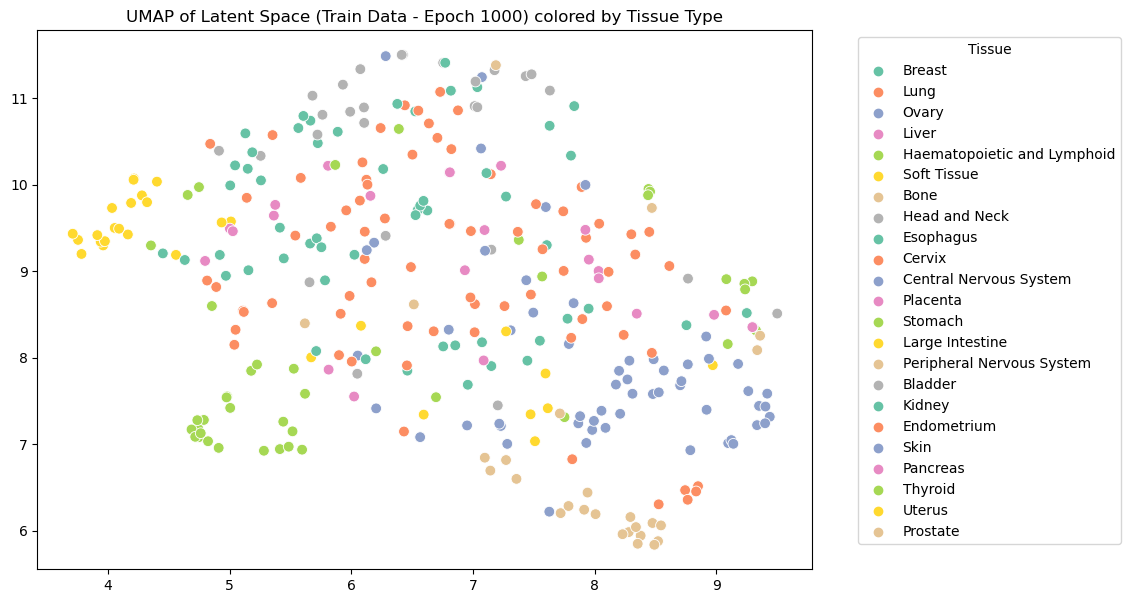

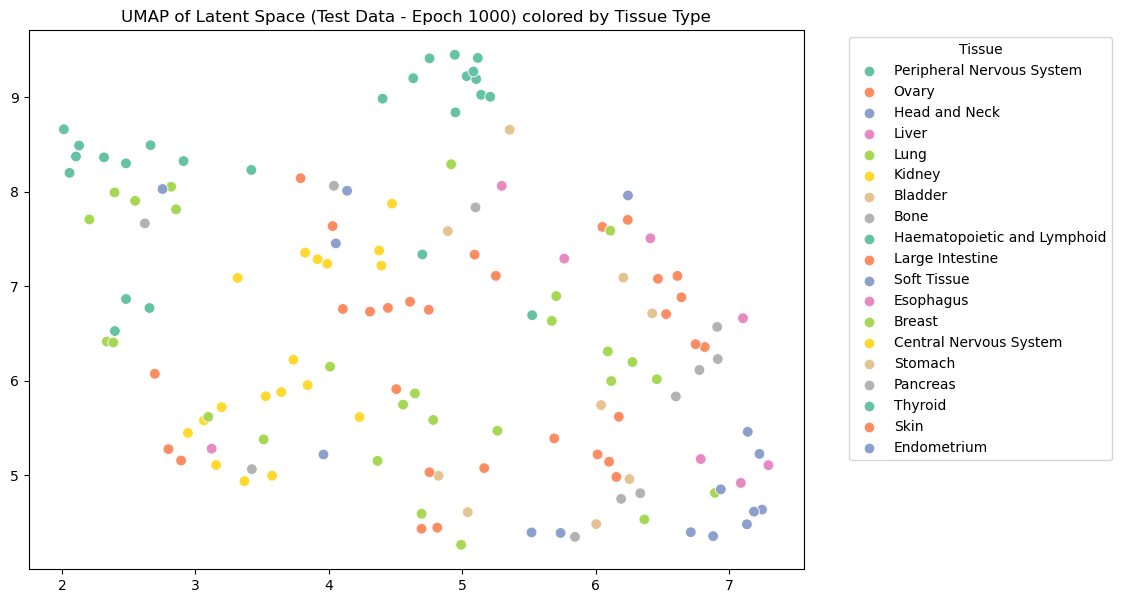

Epoch [1000/1000], Train Loss: 0.2472, Test Loss: 0.8115
Train Calinski-Harabasz Score: 3.8831, Train Davies-Bouldin Score: 3.3124
Test Calinski-Harabasz Score: 3.8303, Test Davies-Bouldin Score: 2.6616


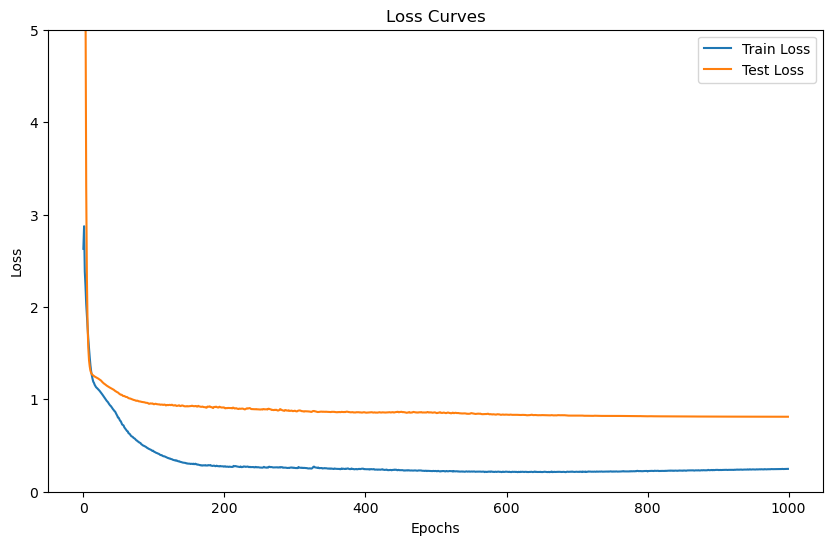

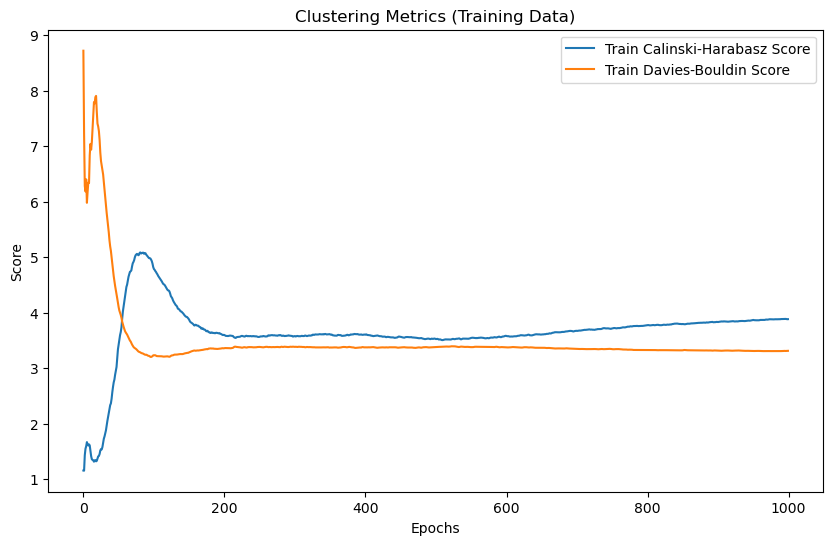

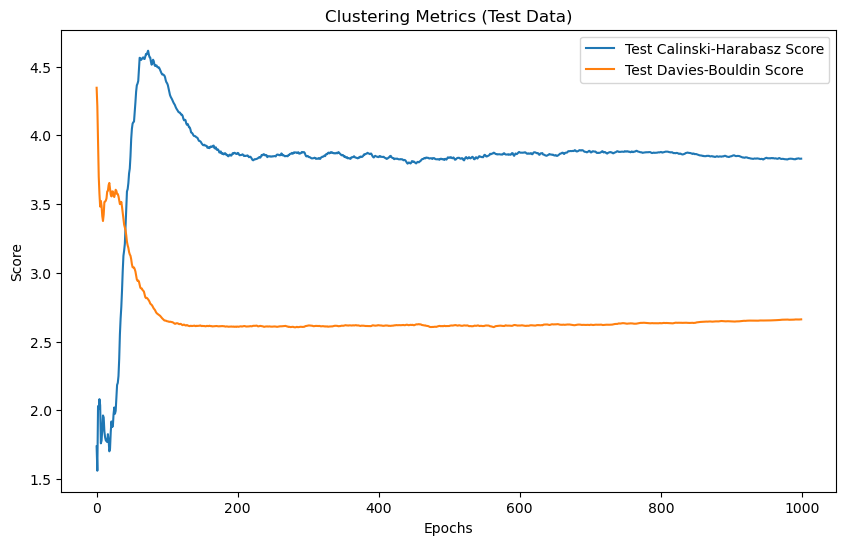

In [5]:


# Data Normalization
scaler = StandardScaler()

combined_mask = np.hstack([mRNA_mask.values, protein_mask.values, shared_cas9_data_mask.values, shared_CNV_data_mask.values, shared_methylation_data_mask.values])
data_combined = np.hstack([shared_mRNA_data.values, shared_protein_data.values, shared_cas9_data.values, shared_CNV_data.values, shared_methylation_data.values])

input_dim = data_combined.shape[1]  # Number of input features


# Set Hyperparameters
hidden_dim = 620  # Hidden dimension
latent_dim = 120  # Latent dimension
num_epochs = 1000  # Number of epochs
batch_size = 150  # Process one graph at a time
learning_rate = 0.0005
weight_decay = 1e-3  # L2 regularization term
dropout_rate = 0.7  # Dropout rate

scaled_data = scaler.fit_transform(data_combined)

# Ensure adj_matrix is a NumPy array
adj_matrix = adj_matrix2.values if isinstance(adj_matrix, pd.DataFrame) else adj_matrix
adj_matrix = torch.tensor(adj_matrix2, dtype=torch.float32)

# Laplacian Matrix Calculation
laplacian_matrix = laplacian(adj_matrix.numpy(), normed=True)
laplacian_matrix = torch.tensor(laplacian_matrix, dtype=torch.float32)
adj_matrix = laplacian_matrix
# Define a custom dataset class
class CustomDataset(Dataset):
    def __init__(self, features, mask, metadata=None):
        self.features = torch.tensor(features, dtype=torch.float32).clone().detach()
        self.mask = torch.tensor(mask, dtype=torch.bool)  # Directly using the combined mask
        self.metadata = metadata
        if metadata is not None:
            self.metadata = torch.tensor(metadata, dtype=torch.float32)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        if self.metadata is not None:
            return self.features[idx], self.mask[idx], self.metadata[idx]
        else:
            return self.features[idx], self.mask[idx], idx


class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, dropout_rate=0.3):
        super(Encoder, self).__init__()
        self.gcn1 = GINConv(nn.Linear(input_dim, hidden_dim))
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.gcn2 = GINConv(nn.Linear(hidden_dim, latent_dim))
        self.bn2 = nn.BatchNorm1d(latent_dim)
        self.dropout = nn.Dropout(dropout_rate)
        self.prelu = nn.PReLU()

        # Linear layer for residual connection to match dimensions
        self.residual_transform = nn.Linear(input_dim, latent_dim)

    def forward(self, x, edge_index):
        x_initial = self.residual_transform(x)  # Transform input for residual connection
        x = self.gcn1(x, edge_index)
        x = self.bn1(x)
        x = self.prelu(x)
        x = self.dropout(x)
        x = self.gcn2(x, edge_index)
        x = self.bn2(x)
        return x + x_initial  # Residual connection


class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim, dropout_rate=0.3):
        super(Decoder, self).__init__()
        self.gcn1 = GINConv(nn.Linear(latent_dim, hidden_dim))
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.gcn2 = GINConv(nn.Linear(hidden_dim, output_dim))
        self.bn2 = nn.BatchNorm1d(output_dim)
        self.prelu = nn.PReLU()
        self.dropout = nn.Dropout(dropout_rate)

        # Linear layer for residual connection to match dimensions
        self.residual_transform = nn.Linear(latent_dim, output_dim)

    def forward(self, x, edge_index):
        x_initial = self.residual_transform(x)  # Transform input for residual connection
        x = self.gcn1(x, edge_index)
        x = self.bn1(x)
        x = self.prelu(x)
        x = self.dropout(x)
        x = self.gcn2(x, edge_index)
        x = self.bn2(x)
        return x + x_initial  # Residual connection


class GraphAutoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, dropout_rate=0.3):
        super(GraphAutoencoder, self).__init__()
        self.encoder = Encoder(input_dim, hidden_dim, latent_dim, dropout_rate)
        self.decoder = Decoder(latent_dim, hidden_dim, input_dim, dropout_rate)

    def forward(self, x, edge_index):
        z = self.encoder(x, edge_index)  # Encode into latent space
        x_recon = self.decoder(z, edge_index)  # Decode back to input space
        return x_recon
# Initialize Model, Loss, and Optimizer
model = GraphAutoencoder(input_dim, hidden_dim, latent_dim, dropout_rate)
criterion = nn.MSELoss(reduction='none')  # Mean Squared Error Loss
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)


# Prepare DataLoader
dataset = CustomDataset(scaled_data, combined_mask)
# Split dataset into training, validation, and test sets
train_size = int(0.7 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Convert adjacency matrix to edge index format
edge_index_full, _ = dense_to_sparse(adj_matrix)
edge_index_full, _ = add_self_loops(edge_index_full, num_nodes=adj_matrix.size(0))



# Training loop
train_losses = []
test_losses = []
train_calinski_harabasz_scores = []
train_davies_bouldin_scores = []
test_calinski_harabasz_scores = []
test_davies_bouldin_scores = []

for epoch in range(num_epochs):
    model.train()
    running_train_loss = 0.0
    for features, mask, batch_indices in train_loader:
        optimizer.zero_grad()

        num_nodes = features.size(0)
        batch_edge_index, _ = subgraph(torch.arange(num_nodes), edge_index_full, relabel_nodes=True, num_nodes=adj_matrix.size(0))

        # Forward pass
        outputs = model(features, batch_edge_index)

        # Compute loss
        MSE = criterion(outputs, features)
        loss = MSE[~mask].mean()  # Exclude imputed values from the loss
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item()

    epoch_train_loss = running_train_loss / len(train_loader)
    train_losses.append(epoch_train_loss)

    # Test Loss
    model.eval()
    running_test_loss = 0.0
    with torch.no_grad():
        for features, mask, batch_indices in test_loader:
            num_nodes = features.size(0)
            batch_edge_index, _ = subgraph(torch.arange(num_nodes), edge_index_full, relabel_nodes=True, num_nodes=adj_matrix.size(0))

            outputs = model(features, batch_edge_index)
            MSE = criterion(outputs, features)
            loss = MSE[~mask].mean()
            running_test_loss += loss.item()

    epoch_test_loss = running_test_loss / len(test_loader)
    test_losses.append(epoch_test_loss)

    # Latent space representation and clustering metrics
    latent_train_representations = []
    latent_test_representations = []
    train_indices = []
    test_indices = []

    with torch.no_grad():
        for features, mask, batch_indices in train_loader:
            batch_edge_index, _ = subgraph(torch.arange(features.size(0)), edge_index_full, relabel_nodes=True, num_nodes=adj_matrix.size(0))
            z = model.encoder(features, batch_edge_index)
            latent_train_representations.append(z)
            train_indices.append(batch_indices)

        for features, mask, batch_indices in test_loader:
            batch_edge_index, _ = subgraph(torch.arange(features.size(0)), edge_index_full, relabel_nodes=True, num_nodes=adj_matrix.size(0))
            z = model.encoder(features, batch_edge_index)
            latent_test_representations.append(z)
            test_indices.append(batch_indices)

    latent_train_representations = torch.cat(latent_train_representations, dim=0).numpy()
    train_indices = torch.cat(train_indices, dim=0).numpy()
    latent_test_representations = torch.cat(latent_test_representations, dim=0).numpy()
    test_indices = torch.cat(test_indices, dim=0).numpy()

    # Clustering scores for train, validation, and test sets
    train_tissue_labels = final_meta_data2["tissue"].values[train_indices]
    test_tissue_labels = final_meta_data2["tissue"].values[test_indices]

    train_calinski_harabasz = calinski_harabasz_score(latent_train_representations, train_tissue_labels)
    train_davies_bouldin = davies_bouldin_score(latent_train_representations, train_tissue_labels)
    train_calinski_harabasz_scores.append(train_calinski_harabasz)
    train_davies_bouldin_scores.append(train_davies_bouldin)

    test_calinski_harabasz = calinski_harabasz_score(latent_test_representations, test_tissue_labels)
    test_davies_bouldin = davies_bouldin_score(latent_test_representations, test_tissue_labels)
    test_calinski_harabasz_scores.append(test_calinski_harabasz)
    test_davies_bouldin_scores.append(test_davies_bouldin)

    # Perform UMAP visualization of latent space at the last epoch
    if epoch == num_epochs - 1:
        umap_reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='euclidean')

        train_umap_embedding = umap_reducer.fit_transform(latent_train_representations)
        plt.figure(figsize=(10, 7))
        sns.scatterplot(x=train_umap_embedding[:, 0], y=train_umap_embedding[:, 1], hue=train_tissue_labels, palette="Set2", s=60)
        plt.title(f"UMAP of Latent Space (Train Data - Epoch {epoch+1}) colored by Tissue Type")
        plt.legend(title="Tissue", bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.show()

        test_umap_embedding = umap_reducer.fit_transform(latent_test_representations)
        plt.figure(figsize=(10, 7))
        sns.scatterplot(x=test_umap_embedding[:, 0], y=test_umap_embedding[:, 1], hue=test_tissue_labels, palette="Set2", s=60)
        plt.title(f"UMAP of Latent Space (Test Data - Epoch {epoch+1}) colored by Tissue Type")
        plt.legend(title="Tissue", bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.show()

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_train_loss:.4f}, Test Loss: {epoch_test_loss:.4f}")
    print(f"Train Calinski-Harabasz Score: {train_calinski_harabasz:.4f}, Train Davies-Bouldin Score: {train_davies_bouldin:.4f}")
    print(f"Test Calinski-Harabasz Score: {test_calinski_harabasz:.4f}, Test Davies-Bouldin Score: {test_davies_bouldin:.4f}")



# Plot loss curves
plt.figure(figsize=(10, 6))
plt.plot(range(num_epochs), train_losses, label='Train Loss')
plt.plot(range(num_epochs), test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curves')
plt.ylim(0,5)
plt.legend()
plt.show()

# Plot clustering metrics for training data
plt.figure(figsize=(10, 6))
plt.plot(range(num_epochs), train_calinski_harabasz_scores, label='Train Calinski-Harabasz Score')
plt.plot(range(num_epochs), train_davies_bouldin_scores, label='Train Davies-Bouldin Score')
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.title('Clustering Metrics (Training Data)')
plt.legend()
plt.show()



# Plot clustering metrics for test data
plt.figure(figsize=(10, 6))
plt.plot(range(num_epochs), test_calinski_harabasz_scores, label='Test Calinski-Harabasz Score')
plt.plot(range(num_epochs), test_davies_bouldin_scores, label='Test Davies-Bouldin Score')
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.title('Clustering Metrics (Test Data)')
plt.legend()
plt.show()
latent_representations = np.concatenate(
    (latent_train_representations, latent_test_representations), axis=0
)

# Step 2: Extract sample IDs in the same order as  latent representations
train_sample_ids = final_meta_data2.index[train_indices]
test_sample_ids = final_meta_data2.index[test_indices]

# Concatenate all sample IDs into a single index array (same order as the latent representations)
all_sample_ids = np.concatenate((train_sample_ids, test_sample_ids))

# Step 3: Create a DataFrame with latent representations and sample IDs as the index
latent_df = pd.DataFrame(data=latent_representations, index=all_sample_ids)

latent_df.index.name = "Sample"
sorted_latent_df = latent_df.reindex(final_meta_data2.index)
sorted_latent_df.to_csv("/home/labpc6c/Documents/Mo_emam/try_Gid2_model.csv")